In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.4. Sociodemographic & Housing Clustering')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.4. Sociodemographic & Housing Clustering/Output')
cur_date = "020223"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)

# reading in files
acs_whp_df = data.frame(read_excel("Input/Imputed_ACS_WHP_Data_020223.xlsx"))
housing_df = data.frame(read_excel("Input/Imputed_Housing_Data_020223.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
# viewing data
head(acs_whp_df)
head(housing_df)

,GEO_ID,Census_Tract,County,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,Sex_Ratio,Median_Age,Population_Under_5,⋯,Some_College,College_Education,Employed,Unemployed,Employed_Male,Employed_Female,Full_Time_Work,Part_Time_Work,No_Work,Average_Income_Deficit
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201.00,Alamance,278233.8,92.23704,1,81-100,87.2,37.3,9.5,⋯,21.1,0.9,91.61621,8.383791,94.24951,89.20607,43.04307,21.93988,35.01704,5016
2,14000US37001020200,202.00,Alamance,278233.8,92.23704,1,81-100,78.3,31.0,7.1,⋯,18.9,12.4,89.54774,10.452261,86.97436,92.01970,39.42970,23.56604,37.00426,4007
3,14000US37001020300,203.00,Alamance,278233.8,92.23704,1,81-100,77.8,40.7,7.3,⋯,22.6,4.6,93.78094,6.219059,92.69841,94.80990,41.09615,18.98616,39.91770,5370
4,14000US37001020400,204.00,Alamance,278233.8,92.23704,1,81-100,78.1,30.5,8.9,⋯,16.3,5.4,91.69985,8.300153,93.36493,90.64532,37.55153,28.40066,34.04782,7148
5,14000US37001020501,205.01,Alamance,278233.8,92.23704,1,81-100,92.7,35.1,5.5,⋯,3.5,1.5,91.14707,8.852927,96.10136,86.41860,45.86115,25.56742,28.57143,7403
6,14000US37001020502,205.02,Alamance,278233.8,92.23704,1,81-100,99.0,32.1,9.8,⋯,10.8,5.2,89.44282,10.557185,89.64942,89.15094,43.57167,22.82645,33.60188,5412


,GEO_ID,Census_Tract,County,Owner_Occupied_Housing_Units,Owner_Occupied_Housing_Units_Less_than_HPI,Median_House_Value,Median_Gross_Rent,Median_Gross_Rent_Percentage_of_Household_Income
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201.00,Alamance,853,604,204300,619,25.2
2,14000US37001020200,202.00,Alamance,686,673,79800,759,33.3
3,14000US37001020301,203.01,Alamance,621,621,95900,847,40.0
4,14000US37001020302,203.02,Alamance,935,906,88700,954,19.9
5,14000US37001020400,204.00,Alamance,1475,1433,85700,767,27.3
6,14000US37001020501,205.01,Alamance,950,845,160200,811,21.2


Using k-means clustering to how GEO IDs cluster based on data from 8 EJ Screen indicators and housing data, seprately. This will be done to prioritize regions of concern in NC based on a higher level of social stressors. 
[source](https://www.epa.gov/ejscreen/overview-socioeconomic-indicators-ejscreen)

In [3]:
# selecting variables we're interested in
ejscreen_indicators = c("Population_Over_65", "Race_Non_White", "Hispanic_Latino", "Population_Under_5",
                          "Non_Proficient_English_Speakers", "Poverty_Overall", "Less_than_High_School", "Unemployed")

housing_indicators = c("Total_Housing_Units", "Median_House_Value", "Median_Gross_Rent_Percentage_of_Household_Income")

# changing the df from a wide to long format 
longer_acs_whp_df = pivot_longer(acs_whp_df, cols = c(5,8:49), names_to = "Variables", values_to = "Value") %>%
    filter(Variables %in% ejscreen_indicators)
longer_housing_df = inner_join(housing_df, acs_whp_df %>%
                                   select(GEO_ID, Total_Housing_Units)) %>%
                                 pivot_longer(cols = c(4:9), names_to = "Variables", values_to = "Value") %>%
    filter(Variables %in% housing_indicators)
                               
head(longer_acs_whp_df)
head(longer_housing_df)

Joining, by = "GEO_ID"


GEO_ID,Census_Tract,County,Avg_ACRES,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,Variables,Value
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
14000US37001020100,201,Alamance,278233.8,1,81-100,Population_Under_5,9.5
14000US37001020100,201,Alamance,278233.8,1,81-100,Population_Over_65,15.1
14000US37001020100,201,Alamance,278233.8,1,81-100,Race_Non_White,39.0
14000US37001020100,201,Alamance,278233.8,1,81-100,Hispanic_Latino,9.5
14000US37001020100,201,Alamance,278233.8,1,81-100,Non_Proficient_English_Speakers,3.9
14000US37001020100,201,Alamance,278233.8,1,81-100,Poverty_Overall,27.2


GEO_ID,Census_Tract,County,Variables,Value
<chr>,<dbl>,<chr>,<chr>,<dbl>
14000US37001020100,201,Alamance,Median_House_Value,204300.0
14000US37001020100,201,Alamance,Median_Gross_Rent_Percentage_of_Household_Income,25.2
14000US37001020100,201,Alamance,Total_Housing_Units,2036.0
14000US37001020200,202,Alamance,Median_House_Value,79800.0
14000US37001020200,202,Alamance,Median_Gross_Rent_Percentage_of_Household_Income,33.3
14000US37001020200,202,Alamance,Total_Housing_Units,1796.0


In [4]:
# wide formatted df w/ ej screen or housing variables and corresponding geo ids
id_ejscreen_df = reshape2::dcast(longer_acs_whp_df, GEO_ID ~ Variables, value.var = "Value") %>% 
    column_to_rownames("GEO_ID") %>%
    # standardizing data
    scale()

id_housing_df = reshape2::dcast(longer_housing_df, GEO_ID ~ Variables, value.var = "Value") %>% 
    column_to_rownames("GEO_ID") %>%
    # standardizing data
    scale()

head(id_ejscreen_df)
head(id_housing_df)

,Hispanic_Latino,Less_than_High_School,Non_Proficient_English_Speakers,Population_Over_65,Population_Under_5,Poverty_Overall,Race_Non_White,Unemployed
14000US37001020100,0.0487693,0.83871273,-0.09975235,-0.2136524,1.4565609,1.0777043,0.3316523,0.55201762
14000US37001020200,2.2734459,0.37203747,2.24955087,-0.7300897,0.5222665,1.6438729,0.7131595,1.01877411
14000US37001020300,4.1214577,0.64282435,2.89026993,0.2895429,0.6001244,0.7474393,1.0056483,0.06353935
14000US37001020400,1.4024085,0.75805280,1.10402286,-0.8757515,1.2229873,1.5117669,2.0908243,0.53314441
14000US37001020501,0.6373081,-1.15473961,1.06519140,-0.1474425,-0.1005964,-0.2056111,-0.3126710,0.65787955
14000US37001020502,1.6966779,0.02635209,1.70591046,-1.0346553,1.5733477,0.8134923,1.1921630,1.04245041


,Median_Gross_Rent_Percentage_of_Household_Income,Median_House_Value,Total_Housing_Units
14000US37001020100,-0.5390177,-0.0612978,0.2251011
14000US37001020200,0.5234929,-0.9962889,-0.1205707
14000US37001020400,-0.2635522,-0.9519800,1.1915417
14000US37001020501,-1.0637144,-0.3924874,-0.3020484
14000US37001020502,1.5335341,-0.6343084,-0.4417574
14000US37001020601,-1.0243623,0.3938063,-0.6203545


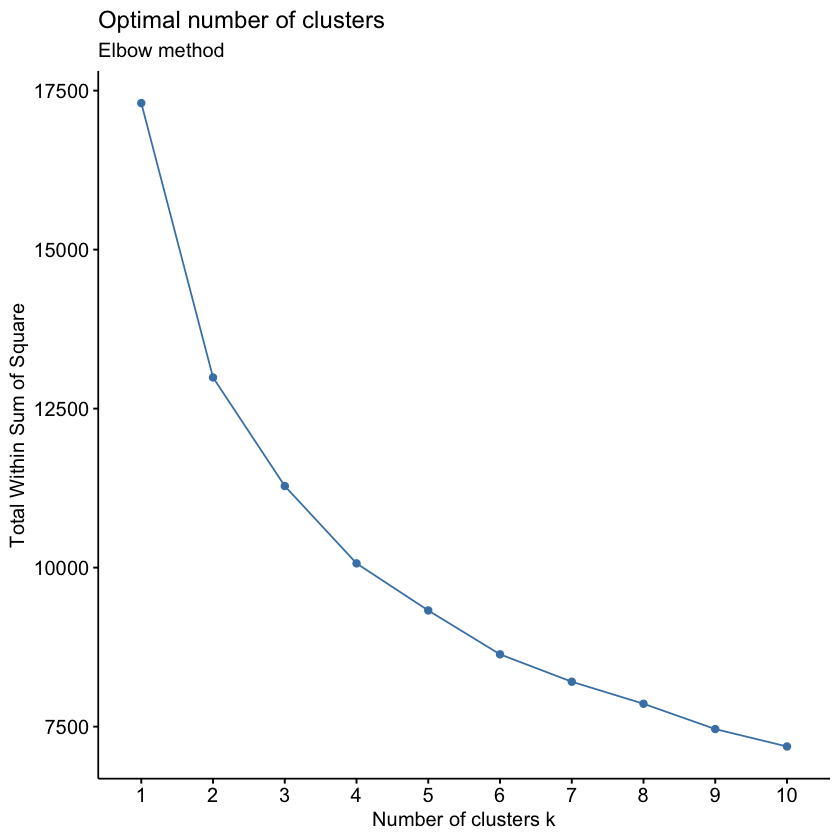

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


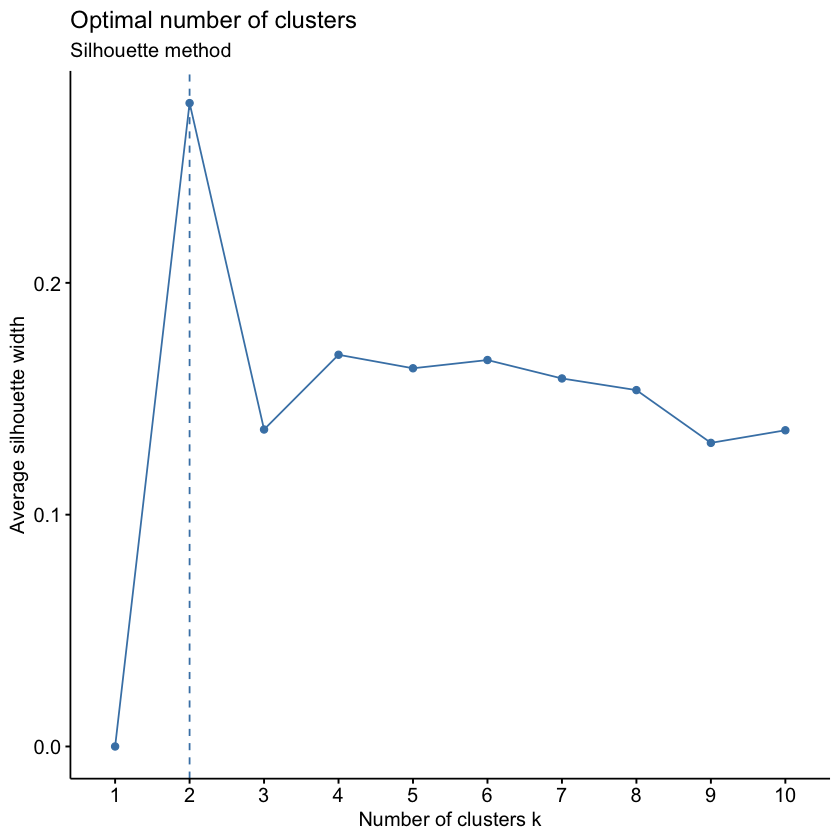

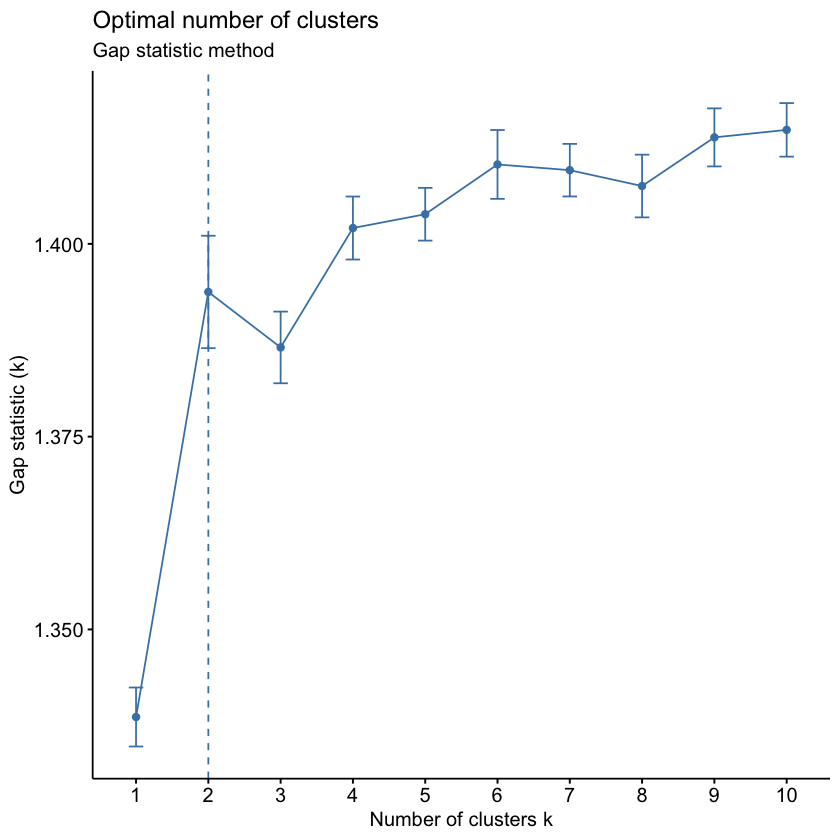

In [5]:
# determining optimal number of clusters using 3 different methods: wss, silhoutte, and gapstat
# ej screen
fviz_nbclust(id_ejscreen_df, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests ??
fviz_nbclust(id_ejscreen_df, kmeans, method = "silhouette") + 
  labs(subtitle = "Silhouette method") # suggests 2
fviz_nbclust(id_ejscreen_df, kmeans, method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method") # suggests 2

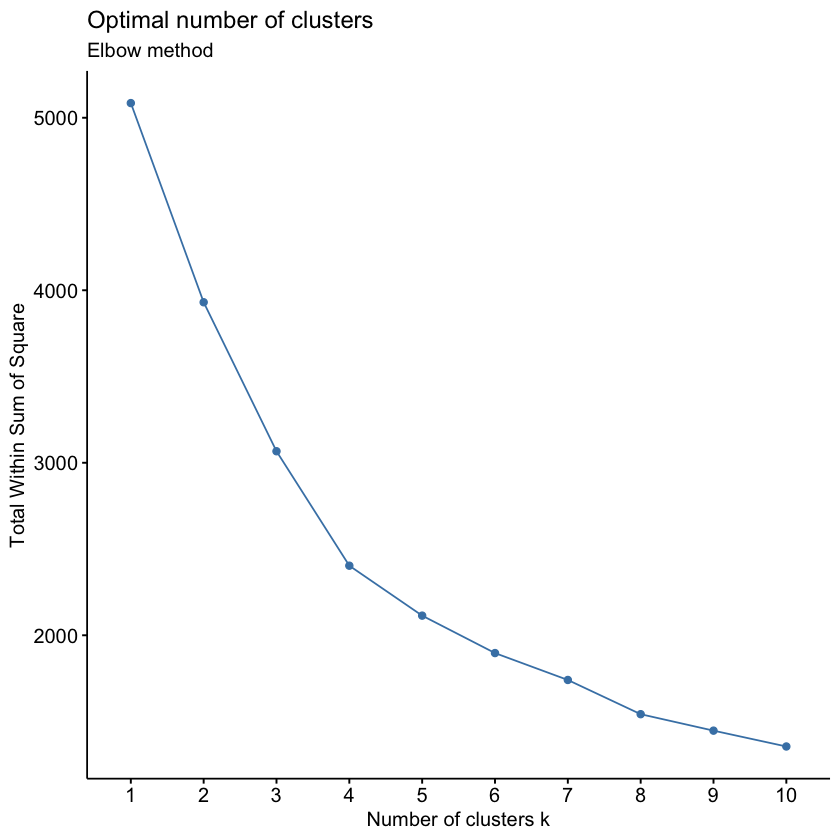

Warning message:
“did not converge in 10 iterations”


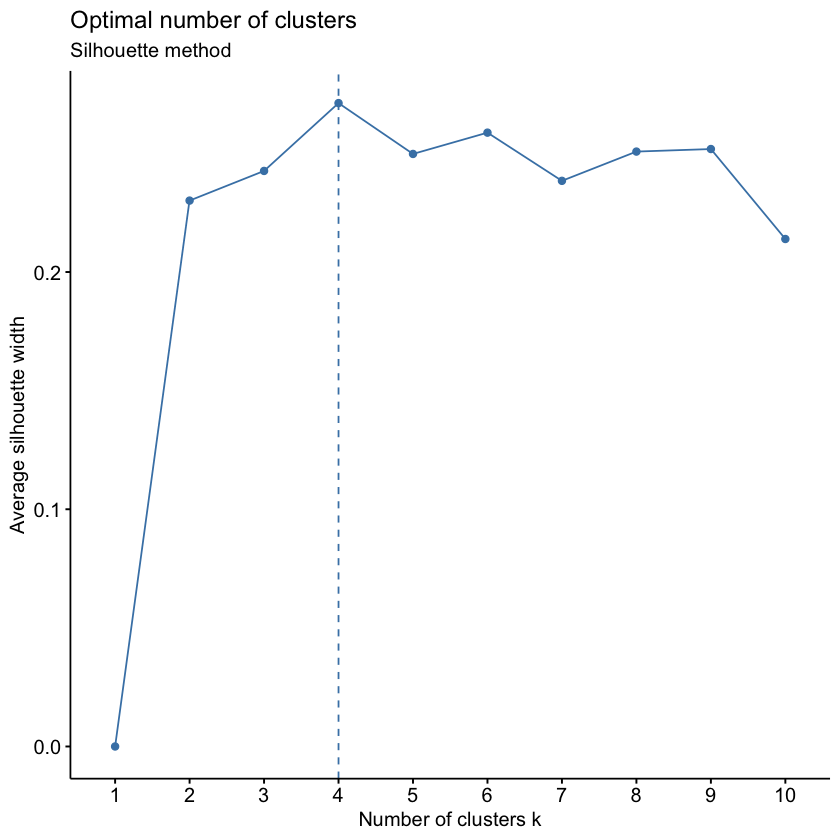

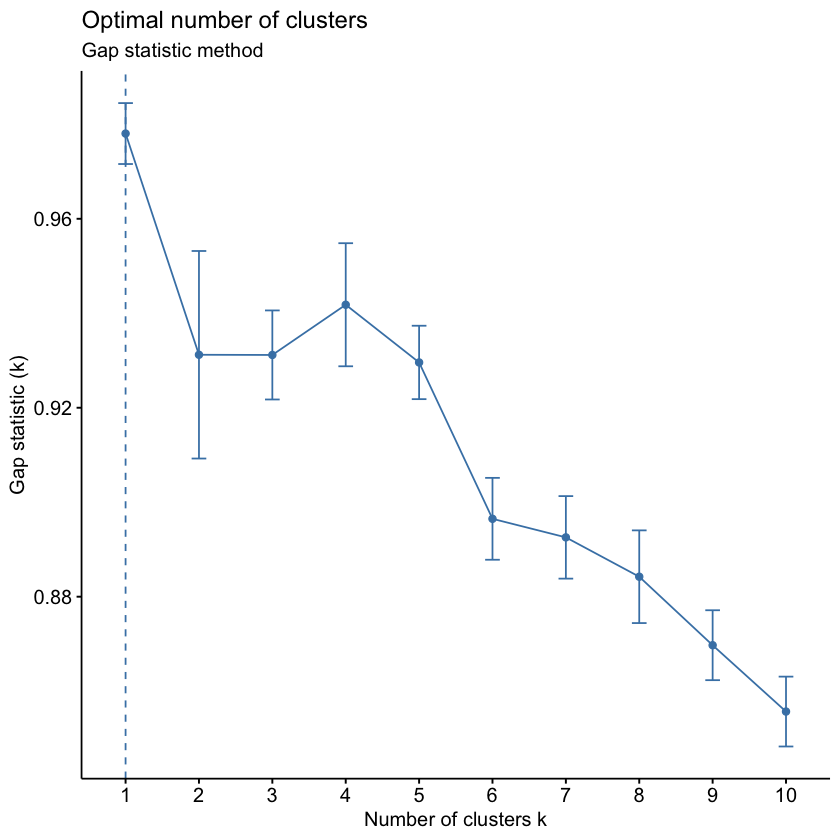

In [6]:
# housing
fviz_nbclust(id_housing_df, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests ??
fviz_nbclust(id_housing_df, kmeans, method = "silhouette") + 
  labs(subtitle = "Silhouette method") # suggests 4
fviz_nbclust(id_housing_df, kmeans, method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method") # suggests 1

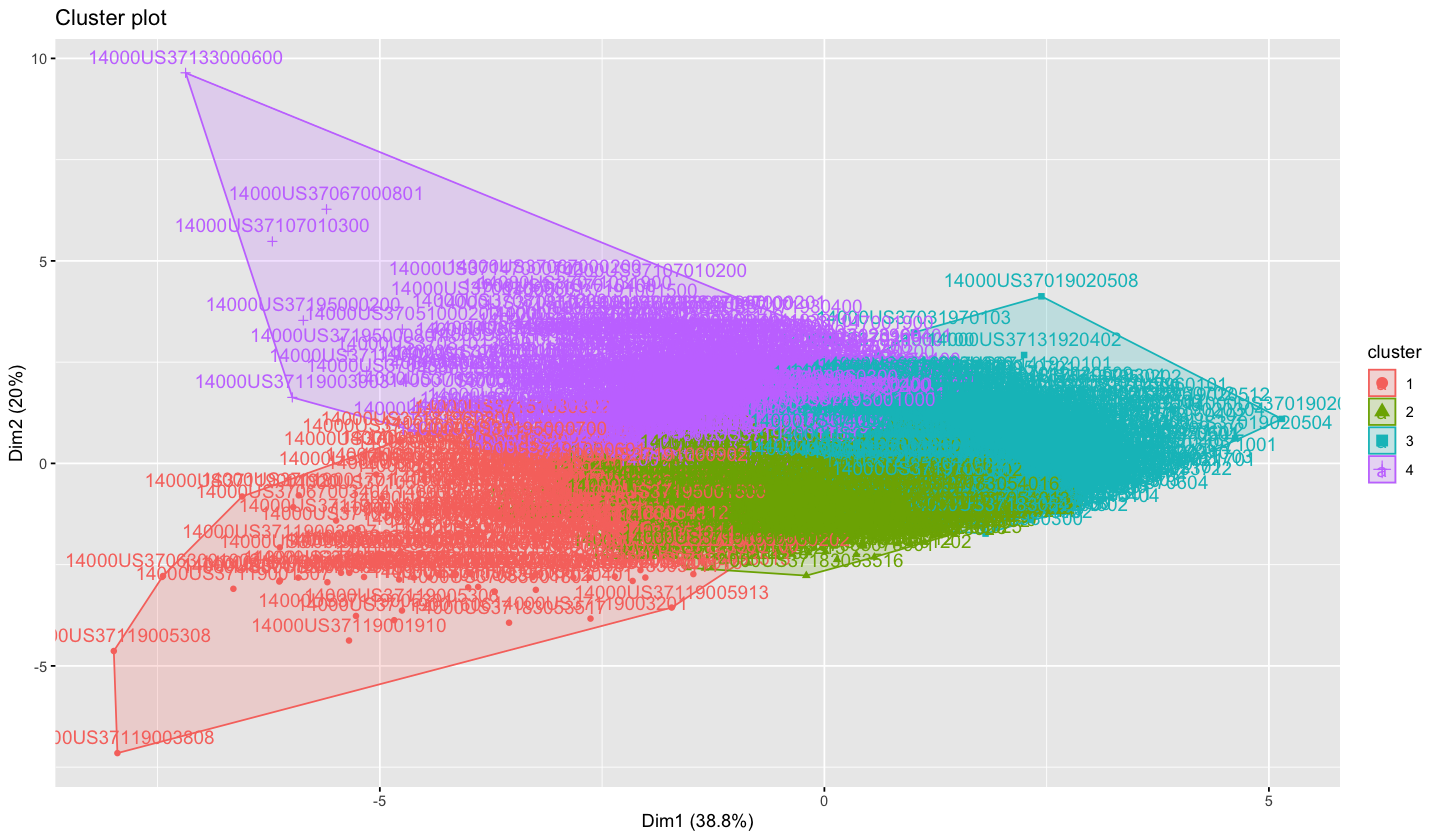

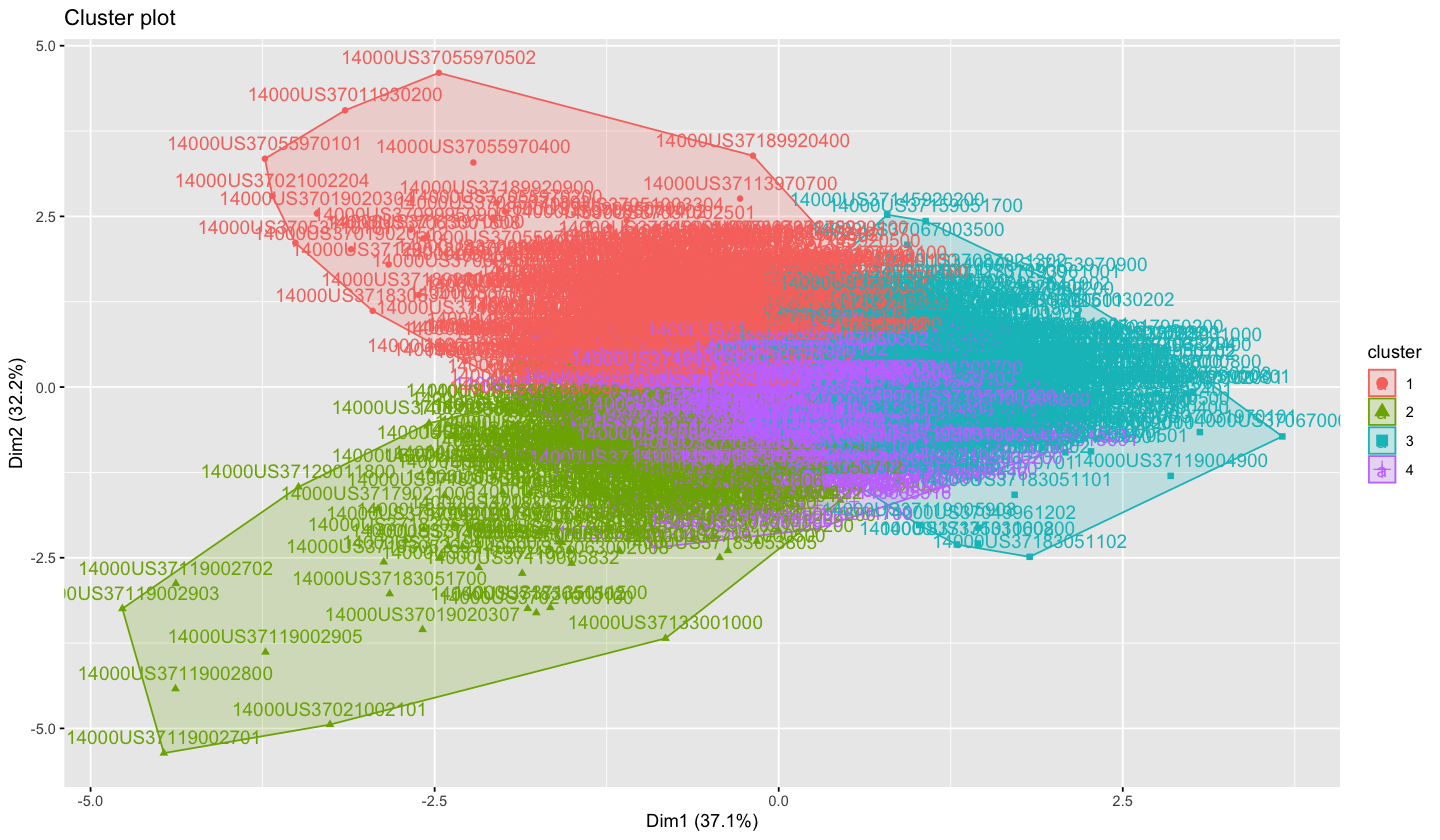

In [7]:
# ended up moving forward with 4 clusters to make mapping of high priority areas more distinct
options(repr.plot.width=12, repr.plot.height=7) #changing size
ejscreen_kmeans = kmeans(id_ejscreen_df, centers = 4, nstart = 25)
fviz_cluster(ejscreen_kmeans, data = id_ejscreen_df) 

# ??
options(repr.plot.width=12, repr.plot.height=7) #changing size
housing_kmeans = kmeans(id_housing_df, centers = 4, nstart = 25)
fviz_cluster(housing_kmeans, data = id_housing_df) 

PCA was only able to capture ~60% of data from the EJ screen indicators, however we're still able to see 4 distinct clusters. PCA was able to capture ~70% of data from the housing indicators!

In [8]:
# extracting geo id cluster assignments
ejscreen_cluster_df = data.frame(ejscreen_kmeans$cluster) %>%
    rownames_to_column(var = "GEO_ID")
colnames(ejscreen_cluster_df)[2] = "Cluster"
head(ejscreen_cluster_df)

housing_cluster_df = data.frame(housing_kmeans$cluster) %>%
    rownames_to_column(var = "GEO_ID")
colnames(housing_cluster_df)[2] = "Cluster"
head(housing_cluster_df)

,GEO_ID,Cluster
,<chr>,<int>
1,14000US37001020100,4
2,14000US37001020200,1
3,14000US37001020300,1
4,14000US37001020400,1
5,14000US37001020501,2
6,14000US37001020502,1


,GEO_ID,Cluster
,<chr>,<int>
1,14000US37001020100,4
2,14000US37001020200,3
3,14000US37001020400,1
4,14000US37001020501,4
5,14000US37001020502,3
6,14000US37001020601,4


In [9]:
# exporting cluster assignments
write.csv(ejscreen_cluster_df, paste0(Output,"/", cur_date, "_GEO_ID_Sociodemographic_Clusters.csv"), row.names = FALSE)
write.csv(housing_cluster_df, paste0(Output,"/", cur_date, "_GEO_ID_Housing_Clusters.csv"), row.names = FALSE)